# Investigating Drive Strengths

We split this section into weak, moderate, and strong drive strengths, w.r.t. the following ranges:
- 0.01 - 0.2: Weak Drive
- 0.2 - 0.5: Moderate Drive
- 0.5 - 1: Strong Drive

Note that we start with all experiments being in a transversal field, followed by a non-transversal field.
Below are the helper functions and libraries being used. Scroll down for the experiments themselves

In [1]:
# Importing Libraries

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from qutip import *

In [2]:
# Baselines for code
rabi   = 0.10 * np.pi   # base drive amplitude
omega_d = 1.0 * np.pi * 0.3372   # drive frequency

omega_0 = 1.0 * np.pi * 0.3373   # resonance frequency
theta = 0.5 * np.pi
g2 = 0.0 # noise
g1 = 0.0

psi0 = basis(2,0)
tlist = np.linspace(0,5000,10000)

solver = "me"

In [3]:
def qubit_integrate_labframe(omega_0, omega_d, rabi, theta,psi0, solver, phi = 0, g1 = 0, g2 = 0):

    H0 = (omega_0/2) * sigmaz()
    H1 = 2 * rabi * np.sin(theta) * sigmax()
    H2 = 2 * rabi * np.cos(theta) * sigmaz()
    
    def H1_coeff(t, args):
        return np.cos(omega_d*t+phi)
        
    def H2_coeff(t, args):
        return np.cos(omega_d*t+phi)
    
    # collapse operators
    c_ops = []

    if g1 > 0.0:
        c_ops.append(np.sqrt(g1) * sigmam())

    if g2 > 0.0:
        c_ops.append(np.sqrt(g2) * sigmaz())

    e_ops = [sigmax(), sigmay(), sigmaz()]
    
    H = [H0, [H1,H1_coeff],  [H2,H2_coeff]]
    
    if solver == "me": # master equation
        output = mesolve(H, psi0, tlist, c_ops, e_ops)  
    elif solver == "es": # exact schrodinger
        output = essolve(H, psi0, tlist, c_ops, e_ops)  
    elif solver == "mc": # monte carlo
        ntraj = 250
        output = mcsolve(H, psi0, tlist, ntraj, c_ops, e_ops)  
    else:
        raise ValueError("unknown solver")
        
    return output.expect[0], output.expect[1], output.expect[2] # Time-dependent expectation values of the qubit’s Pauli operators

### Additional Functions

To help with analysis, I've designed additional helper functions to look at the fourier transform of different frequencies, making it easier to analyse. These are defined below:

In [4]:
import numpy as np
from scipy.signal import find_peaks

def compute_psd_and_peaks(omega_0,omega_d,rabi_list,theta,psi0,solver,tlist,prominence_frac=0.05):
    
    psd_results = []
    results_summary = {}
    all_peak_freqs = set()

    for rabi in rabi_list:
        sx, sy, sz = qubit_integrate_labframe(
            omega_0=omega_0,
            omega_d=omega_d,
            rabi=rabi,
            theta=theta,
            psi0=psi0,
            solver=solver
        )

        freqs = np.fft.fftfreq(len(tlist), tlist[1] - tlist[0])
        psd = np.abs(np.fft.fft(sz))**2
        psd_results.append(psd)

        # Positive frequencies only (spectrum is symmetric)
        mask = freqs > 0
        freqs_pos = freqs[mask]
        psd_pos = psd[mask]

        peaks, _ = find_peaks(
            psd_pos,
            prominence=np.max(psd_pos) * prominence_frac
        )

        peak_data = [(freqs_pos[p], psd_pos[p]) for p in peaks]
        results_summary[rabi] = peak_data

        for f, _ in peak_data:
            all_peak_freqs.add(f)

    return freqs, psd_results, results_summary, all_peak_freqs


In [5]:
import matplotlib.pyplot as plt

def plot_psd_and_print_peaks(freqs,psd_results,results_summary,all_peak_freqs,rabi_list,omega_d,max_ticks=12):
    # -------------------------
    # Plot Power Spectral Density
    # -------------------------

    plt.figure(figsize=(16, 10))

    for psd, rabi in zip(psd_results, rabi_list):
        plt.plot(freqs[freqs > 0], psd[freqs > 0],
                 label=f"Ω={rabi/np.pi:.2f}π")

    # X-axis ticks based on unique peak frequencies
    unique_freqs = sorted(all_peak_freqs)
    if len(unique_freqs) > max_ticks:
        step = len(unique_freqs) // max_ticks
        unique_freqs = unique_freqs[::step]

    plt.xticks(unique_freqs, rotation=45)
    plt.xlim(0, omega_d)
    plt.xlabel("Frequency")
    plt.ylabel("PSD")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nSpectral Peaks by Drive Strength:\n")

    for rabi, peaks in results_summary.items():
        print(f"{rabi/np.pi:.2f}π:")
        if not peaks:
            print("  (No significant peaks found)")
        for f, amp in peaks:
            print(f"  (Freq: {f:.3f}, Amp: {amp:.3e})")
        print()


## Transversal Scenarios

In the following section, we only deal with driving fields that are purely transversal.

### Weak Drives

We start with weak drives, looking at a range between 0.01 and 0.2 as a drive amplitude scalar.

C:\Users\sachh\anaconda3\Lib\site-packages\qutip\solver\solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


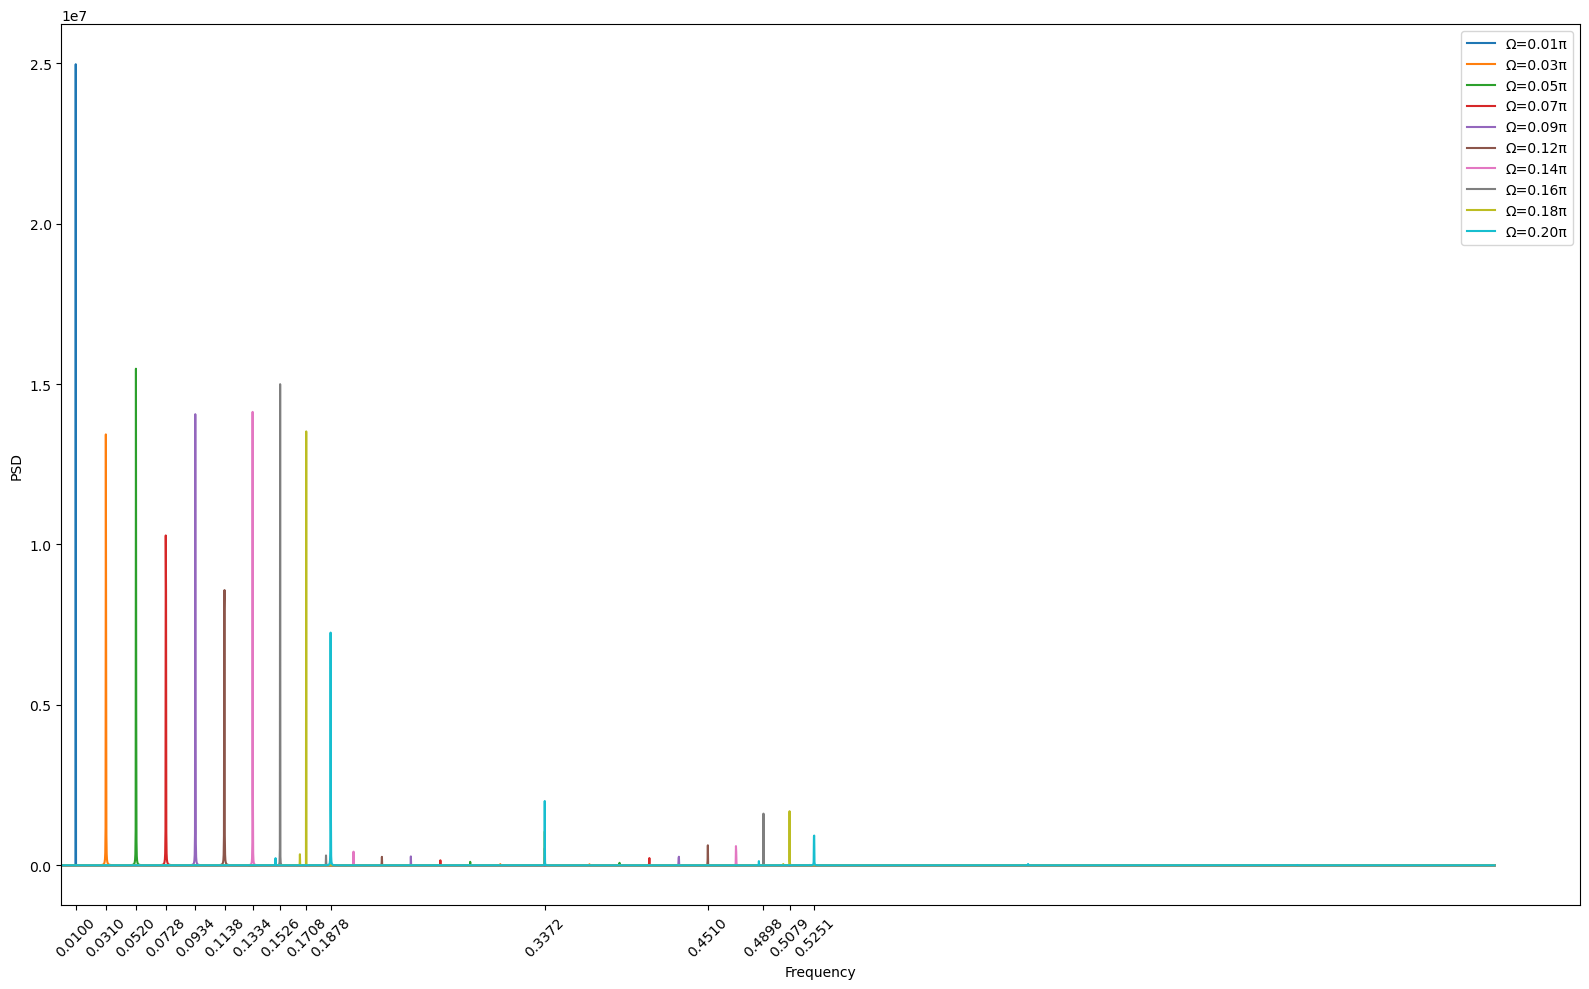


Spectral Peaks by Drive Strength:

0.01π:
  (Freq: 0.010, Amp: 2.497e+07)

0.03π:
  (Freq: 0.031, Amp: 1.343e+07)

0.05π:
  (Freq: 0.052, Amp: 1.548e+07)

0.07π:
  (Freq: 0.073, Amp: 1.028e+07)

0.09π:
  (Freq: 0.093, Amp: 1.406e+07)

0.12π:
  (Freq: 0.114, Amp: 8.578e+06)
  (Freq: 0.451, Amp: 6.230e+05)

0.14π:
  (Freq: 0.133, Amp: 1.413e+07)

0.16π:
  (Freq: 0.153, Amp: 1.499e+07)
  (Freq: 0.490, Amp: 1.610e+06)

0.18π:
  (Freq: 0.171, Amp: 1.352e+07)
  (Freq: 0.337, Amp: 1.055e+06)
  (Freq: 0.508, Amp: 1.685e+06)

0.20π:
  (Freq: 0.188, Amp: 7.252e+06)
  (Freq: 0.337, Amp: 2.004e+06)
  (Freq: 0.525, Amp: 9.262e+05)



In [6]:
theta = np.pi / 2

# Upper limit of 10 because mpl cycle colors afterwards
rabi_list = np.linspace(0.01, 0.20, 10) * np.pi

freqs, psd_results, results_summary, all_peak_freqs = compute_psd_and_peaks(omega_0,omega_d,rabi_list,theta,psi0,solver,tlist)
plot_psd_and_print_peaks(freqs,psd_results,results_summary,all_peak_freqs,rabi_list,omega_d)


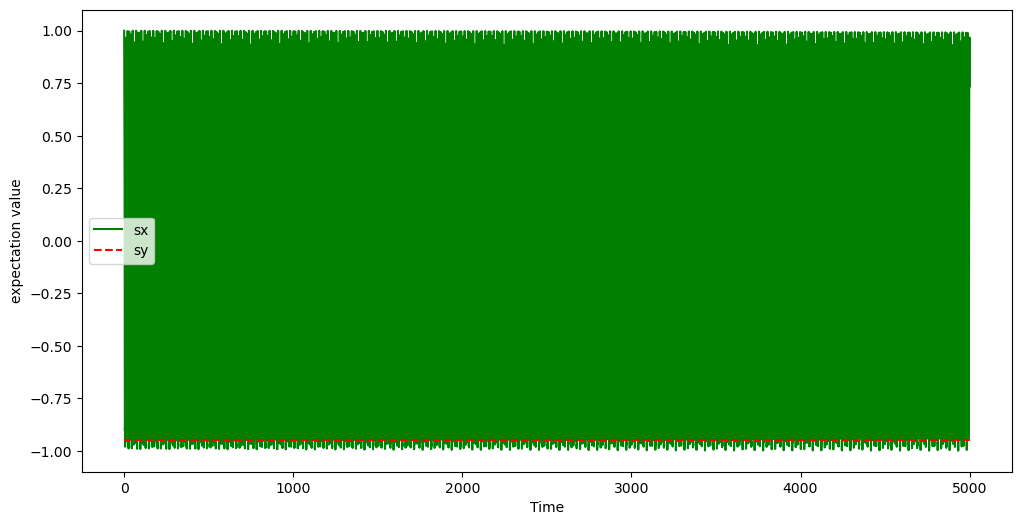

In [7]:
# Playground - Weak Drive Strengths:

# MODIFY ONLY THE BELOW LINE ------
rabi_strength = np.pi * 0.01
# MODIFY ONLY THE ABOVE LINE ------

_, _, sz_brwa_d = qubit_integrate_labframe(omega_0, omega_d, rabi, theta, psi0,"me", g1, g2)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tlist, np.real(sz_brwa_d), 'g')
ax.plot((np.min(tlist),np.max(tlist)),(-0.95, -0.95), 'r--' )
ax.legend(("sx", "sy", "sz"))
ax.set_xlabel('Time')
ax.set_ylabel('expectation value');

#### Analysis: 

### Moderate Drive Strength



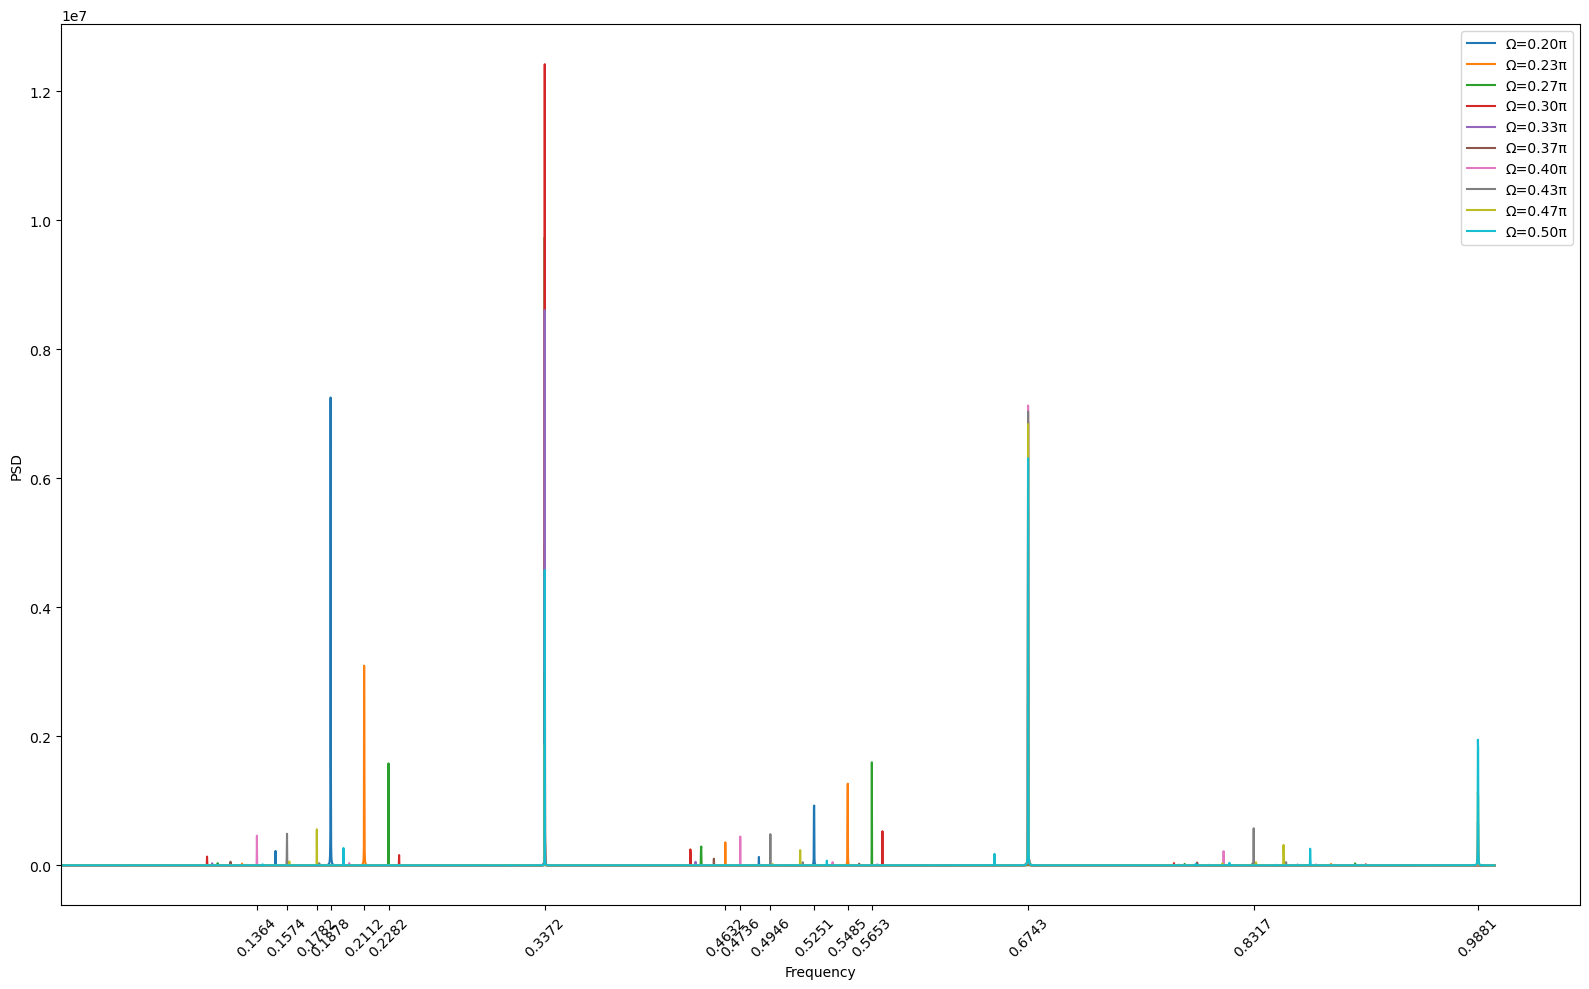


Spectral Peaks by Drive Strength:

0.20π:
  (Freq: 0.188, Amp: 7.252e+06)
  (Freq: 0.337, Amp: 2.004e+06)
  (Freq: 0.525, Amp: 9.262e+05)

0.23π:
  (Freq: 0.211, Amp: 3.095e+06)
  (Freq: 0.337, Amp: 4.956e+06)
  (Freq: 0.463, Amp: 3.557e+05)
  (Freq: 0.549, Amp: 1.265e+06)

0.27π:
  (Freq: 0.228, Amp: 1.580e+06)
  (Freq: 0.337, Amp: 9.736e+06)
  (Freq: 0.565, Amp: 1.596e+06)
  (Freq: 0.674, Amp: 1.031e+06)

0.30π:
  (Freq: 0.337, Amp: 1.242e+07)
  (Freq: 0.674, Amp: 3.062e+06)

0.33π:
  (Freq: 0.337, Amp: 8.608e+06)
  (Freq: 0.674, Amp: 5.552e+06)

0.37π:
  (Freq: 0.337, Amp: 3.013e+06)
  (Freq: 0.674, Amp: 6.878e+06)

0.40π:
  (Freq: 0.136, Amp: 4.590e+05)
  (Freq: 0.474, Amp: 4.454e+05)
  (Freq: 0.674, Amp: 7.129e+06)
  (Freq: 0.988, Amp: 3.971e+05)

0.43π:
  (Freq: 0.157, Amp: 4.891e+05)
  (Freq: 0.495, Amp: 4.825e+05)
  (Freq: 0.674, Amp: 7.033e+06)
  (Freq: 0.832, Amp: 5.738e+05)
  (Freq: 0.988, Amp: 6.667e+05)

0.47π:
  (Freq: 0.178, Amp: 5.580e+05)
  (Freq: 0.337, Amp: 1.868e+0

In [8]:
rabi_list = np.linspace(0.2, 0.5, 10) * np.pi

freqs, psd_results, results_summary, all_peak_freqs = compute_psd_and_peaks(omega_0,omega_d,rabi_list,theta,psi0,solver,tlist)
plot_psd_and_print_peaks(freqs,psd_results,results_summary,all_peak_freqs,rabi_list,omega_d)

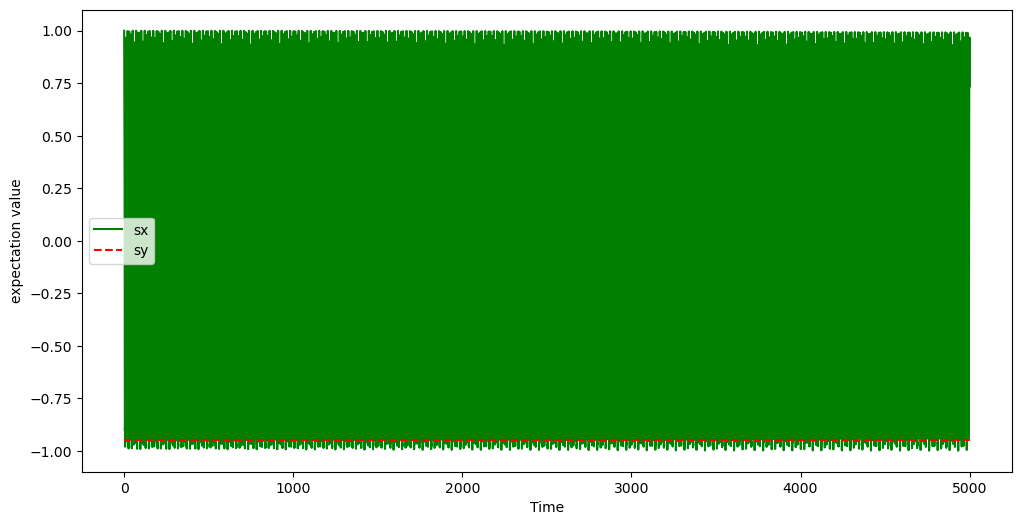

In [9]:
# Playground - Moderate Drive Strengths:

# MODIFY ONLY THE BELOW LINE ------
rabi_strength = np.pi * 0.2
# MODIFY ONLY THE ABOVE LINE ------

_, _, sz_brwa_d = qubit_integrate_labframe(omega_0, omega_d, rabi, theta, psi0,"me", g1, g2)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tlist, np.real(sz_brwa_d), 'g')
ax.plot((np.min(tlist),np.max(tlist)),(-0.95, -0.95), 'r--' )
ax.legend(("sx", "sy", "sz"))
ax.set_xlabel('Time')
ax.set_ylabel('expectation value');

#### Analysis: Moderate Drives

### Strong Drives

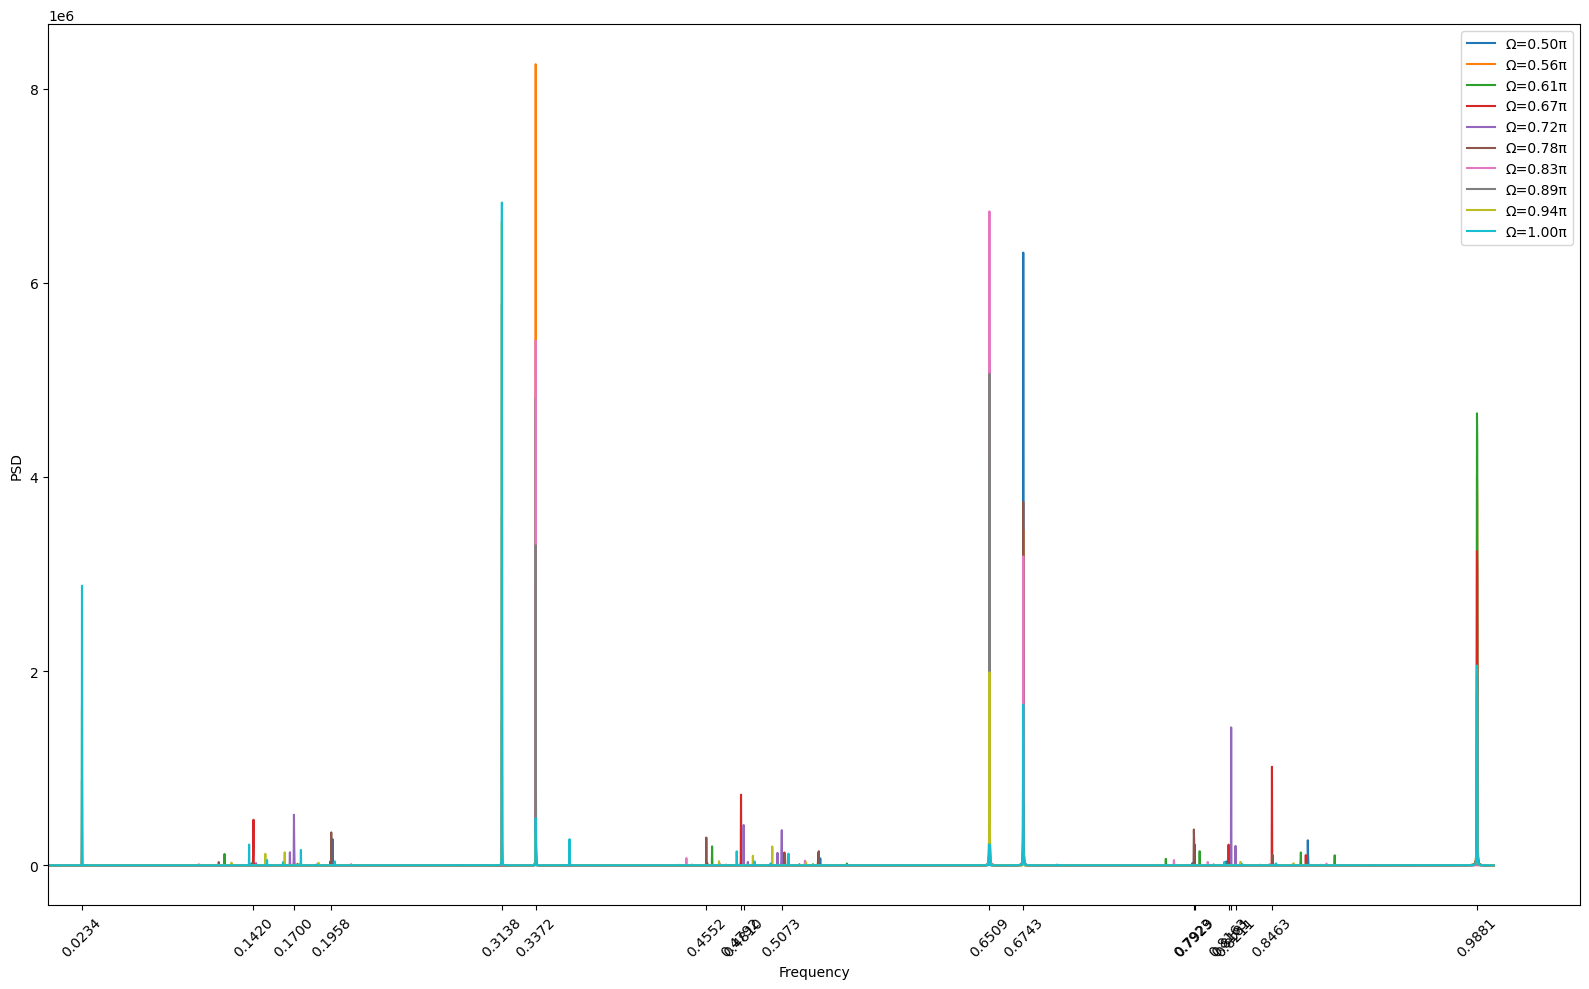


Spectral Peaks by Drive Strength:

0.50π:
  (Freq: 0.337, Amp: 4.577e+06)
  (Freq: 0.674, Amp: 6.311e+06)
  (Freq: 0.988, Amp: 1.946e+06)

0.56π:
  (Freq: 0.337, Amp: 8.252e+06)
  (Freq: 0.651, Amp: 6.790e+05)
  (Freq: 0.674, Amp: 3.457e+06)
  (Freq: 0.988, Amp: 3.998e+06)

0.61π:
  (Freq: 0.337, Amp: 4.812e+06)
  (Freq: 0.651, Amp: 1.546e+06)
  (Freq: 0.674, Amp: 2.433e+05)
  (Freq: 0.988, Amp: 4.656e+06)

0.67π:
  (Freq: 0.142, Amp: 4.694e+05)
  (Freq: 0.314, Amp: 2.170e+05)
  (Freq: 0.337, Amp: 5.519e+05)
  (Freq: 0.479, Amp: 7.277e+05)
  (Freq: 0.651, Amp: 2.295e+06)
  (Freq: 0.674, Amp: 5.252e+05)
  (Freq: 0.793, Amp: 2.121e+05)
  (Freq: 0.816, Amp: 2.125e+05)
  (Freq: 0.846, Amp: 1.015e+06)
  (Freq: 0.988, Amp: 3.235e+06)

0.72π:
  (Freq: 0.170, Amp: 5.208e+05)
  (Freq: 0.314, Amp: 5.373e+05)
  (Freq: 0.337, Amp: 3.297e+05)
  (Freq: 0.481, Amp: 4.150e+05)
  (Freq: 0.507, Amp: 3.619e+05)
  (Freq: 0.651, Amp: 3.329e+06)
  (Freq: 0.674, Amp: 2.218e+06)
  (Freq: 0.818, Amp: 1.421e+0

In [10]:
rabi_list = np.linspace(0.5, 1, 10) * np.pi

freqs, psd_results, results_summary, all_peak_freqs = compute_psd_and_peaks(omega_0,omega_d,rabi_list,theta,psi0,solver,tlist)
plot_psd_and_print_peaks(freqs,psd_results,results_summary,all_peak_freqs,rabi_list,omega_d)

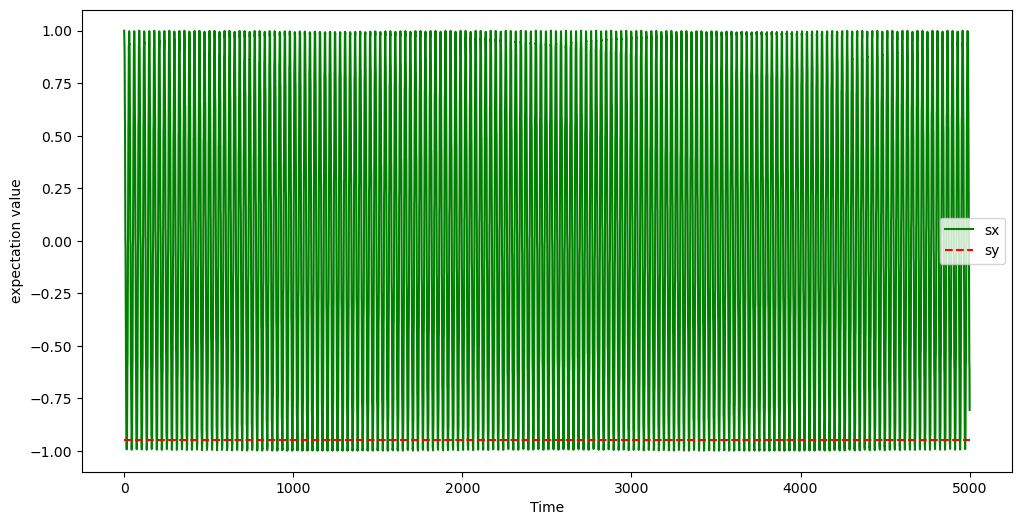

In [12]:
# Playground - Strong Drive Strengths:

# MODIFY ONLY THE BELOW LINE ------
rabi_strength = np.pi * 1
# MODIFY ONLY THE ABOVE LINE ------

_, _, sz_brwa_d = qubit_integrate_labframe(omega_0, omega_d, rabi, theta, psi0,"me", g1, g2)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tlist, np.real(sz_brwa_d), 'g')
ax.plot((np.min(tlist),np.max(tlist)),(-0.95, -0.95), 'r--' )
ax.legend(("sx", "sy", "sz"))
ax.set_xlabel('Time')
ax.set_ylabel('expectation value');

## Non-transversal Scenarios